In [10]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# @Date    : Dec-01-20 21:21
# @Author  : Kelly Hwong (dianhuangkan@gmail.com)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

## Dataset

In [3]:
from utils.load_data import load_data
(train_images, train_labels), (test_images, test_labels) = load_data(dataset="mnist", if_categorical=True, if_expand_dims=True)

In [4]:
# num_classes = 10
# from models.keras_fn.attention_lenet import AttentionLeNet5
# model = AttentionLeNet5(input_shape=input_shape, num_classes=num_classes, attention="senet")
# model.summary()

In [5]:
input_shape = train_images.shape[1:]
num_classes = train_labels.shape[1]
from models.keras_fn.lenet import LeNet5
model = LeNet5(input_shape=input_shape, num_classes=num_classes)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_2 (Dense)              (None, 84)                1

In [6]:
layers = model.layers
for layer in layers:
    print(layer.name)

conv2d_1
max_pooling2d_1
conv2d_2
max_pooling2d_2
flatten
dense_1
dense_2
dense_3


### 获取 checkpoint

```tf.train.latest_checkpoint(ckpt_dir)``` API

In [7]:
model_name = "LeNet5"
# date_time = "20210205-211540" # win
# date_time = "20201201-181130" # mac, invalid checkpoint weights
date_time = "20210207-163951" # mac, retrain
prefix = os.path.join("~", "Documents", "DeepLearningData", "mnist")
subfix = os.path.join(model_name, date_time)
ckpt_dir = os.path.expanduser(os.path.join(prefix, subfix, "ckpts"))

# Load model's last checkpoint if there is any
latest_ckpt = tf.train.latest_checkpoint(ckpt_dir)
if latest_ckpt is not None:
    print(f"Latest checkpoint: {latest_ckpt} loaded!")
    model.load_weights(latest_ckpt)

Latest checkpoint: /Users/HuangKan/Documents/DeepLearningData/mnist/LeNet5/20210207-163951/ckpts/LeNet5-epoch-100-binary_accuracy-0.9992 loaded!


### 获取 model 某一层

```model.layers``` 序列化层列表

```model.get_layer(layer_name)``` 通过layer名称获取层

### 设置 feature 提取器的那一层

extractor 会与 model 共享中间的权重

In [18]:
extractor = Model(model.inputs, model.get_layer("dense_2").output)
extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)              

features.shape: (1, 84)
scores: [[ -54.77639   -94.76598  -178.49954   -21.335306 -306.35287    -6.832787
   -36.972897 -132.77058   -38.06333   -52.27949 ]]
results: [[1.5078473e-21 0.0000000e+00 0.0000000e+00 5.0307830e-07 0.0000000e+00
  9.9999952e-01 8.1342275e-14 0.0000000e+00 2.7336720e-14 1.8312459e-20]]
predicted label: 5
actual label: 5


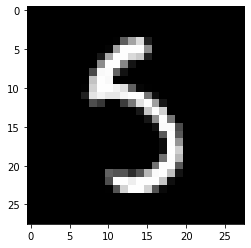

In [19]:
sample_no = 4942 # np.random.choice(test_images.shape[0])
test_sample = np.expand_dims(test_images[sample_no], 0)
features = extractor.predict(test_sample)
print(f"features.shape: {features.shape}")

a = model.get_layer("dense_3").weights[0]
b = model.get_layer("dense_3").weights[1]
scores = features @ a + b
print(f"scores: {scores}")
results = tf.keras.layers.Activation('softmax')(scores)

print(f"results: {results}")
print(f"predicted label: {np.argmax(results)}")
print(f"actual label: {np.argmax(test_labels[sample_no])}")

plt.imshow(test_sample[0,:,:,0], cmap="gray") # 因为之前把 image expand 到 (28, 28, 1)，所以这里必须索引最后一个维度（通道维）

### 特征分布 Distribution of features

In [20]:
hist, bin_edges = np.histogram(features.T, bins=100) # bins=10

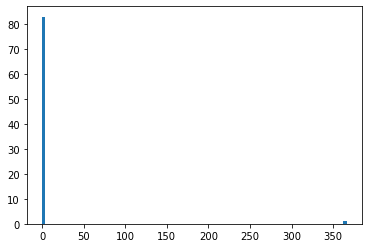

In [21]:
 _ = plt.hist(features.T, bins=bin_edges)

In [22]:
features_cut = np.clip(features, a_min=None, a_max=0.0001) # 84维的特征密集集中在 (0, 0,0001) 范围

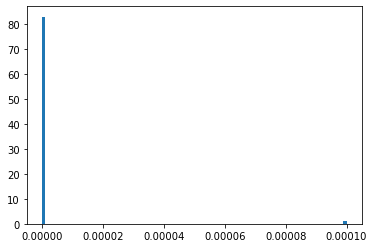

In [23]:
hist, bin_edges = np.histogram(features_cut.T, bins=100) # bins=10
_ = plt.hist(features_cut.T, bins=bin_edges)

### t-SNE 分析

#### Extract feetures

In [27]:
test_features = extractor.predict(test_images, batch_size=32, verbose=1, workers=4, use_multiprocessing=True)

313/313 [==============================] - 1s 2ms/step


In [31]:
print(f"test_images.shape: {test_images.shape}")
print(f"test_features.shape: {test_features.shape}")

test_images.shape: (10000, 28, 28, 1)
test_features.shape: (10000, 84)


In [32]:
from sklearn.manifold import TSNE

In [41]:
%%time
test_features_embedded = TSNE(n_components=2).fit_transform(test_features)
print("Embedding MNIST's features from LeNet5 by t-SNE takes time: ")

CPU times: user 6min 30s, sys: 25.2 s, total: 6min 55s
Wall time: 1min 8s


In [42]:
test_features_embedded.shape

(10000, 2)

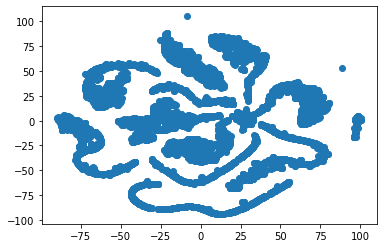

In [45]:
plt.scatter(test_features_embedded[:, 0], test_features_embedded[:, 1])

In [60]:
test_labels_numeric = np.argmax(test_labels, axis=1)

[-1.381019 18.441654]
7


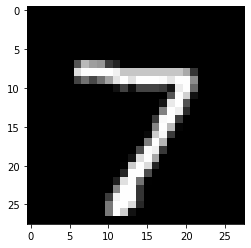

In [63]:
print(test_features_embedded[0])
print(test_labels_numeric[0])
plt.imshow(test_images[0], cmap="gray")

In [65]:
# test_features_embedded
# TODO
def normailize(X):
    """Normailize 2D embedded data
    X: 2D data with shape (N, 2)
    """
    # Normailize on x
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)                        

    # Normailize on y

    return X

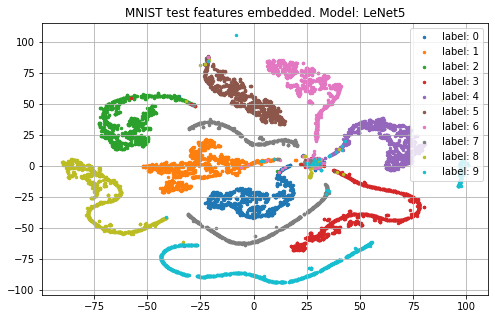

Embedding MNIST's features from LeNet5 using t-SNE takes time: 
CPU times: user 1.76 s, sys: 99.9 ms, total: 1.86 s
Wall time: 1.87 s


In [131]:
%%time
X, target = test_features_embedded, test_labels_numeric
# X = normailize(X)

model_name = "LeNet5"
plt.figure(figsize=(8, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for t in range(num_classes):
    indices = np.where(target==t)[0]
    plt.scatter(X[indices, 0], X[indices, 1], color=colors[t], s=6, label=f"label: {t}")
plt.title(f"MNIST test features embedded. Model: {model_name}")
plt.legend()
plt.grid()
plt.show()
print("Plotting MNIST's t-SNE embedded features from LeNet5 takes time: ")